In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
df = pd.read_csv('datasets/climate-data.csv')

In [3]:
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index(keys='date', inplace=True)
df.sort_index(inplace=True)

In [6]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

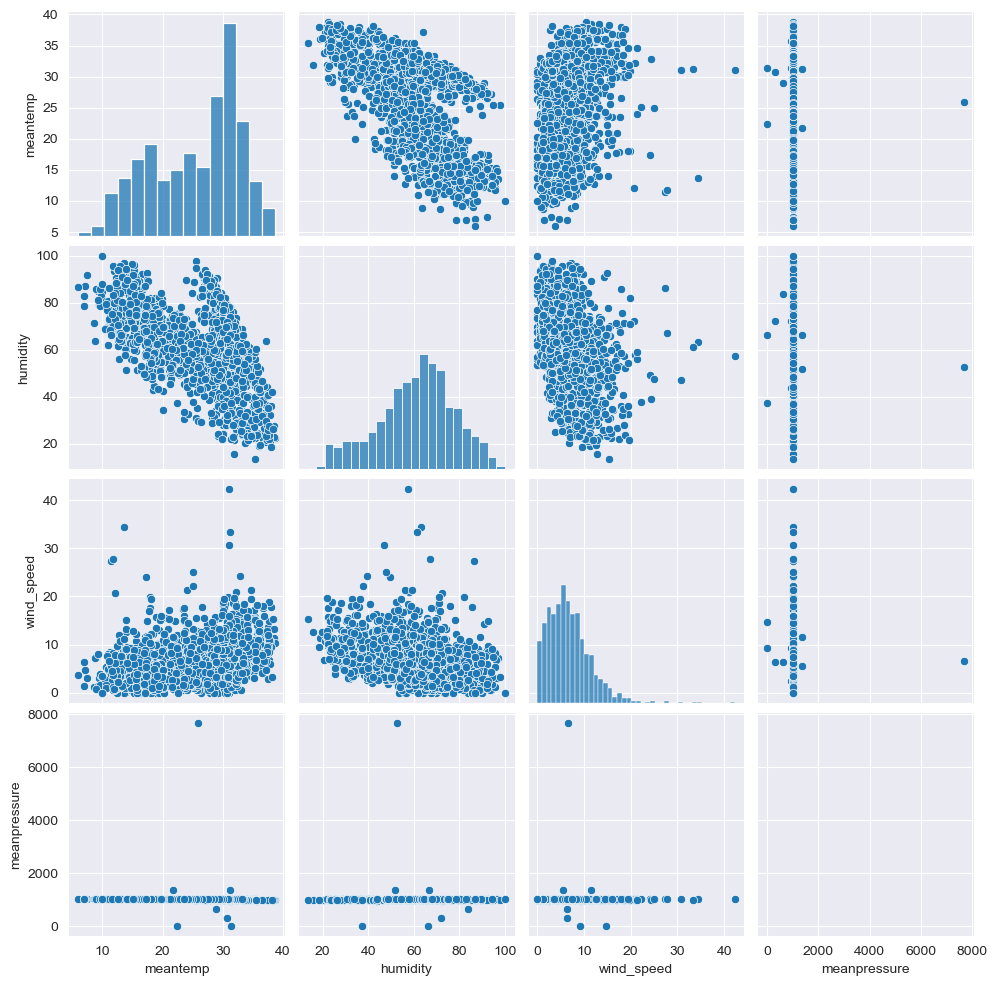

In [7]:
sns.pairplot(df)

<Axes: >

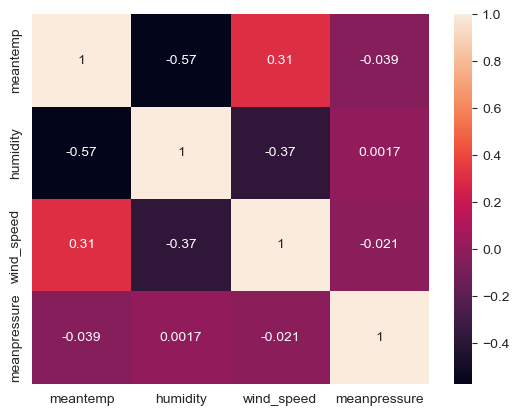

In [8]:
sns.heatmap(df.corr(), annot=True)

<Axes: ylabel='Frequency'>

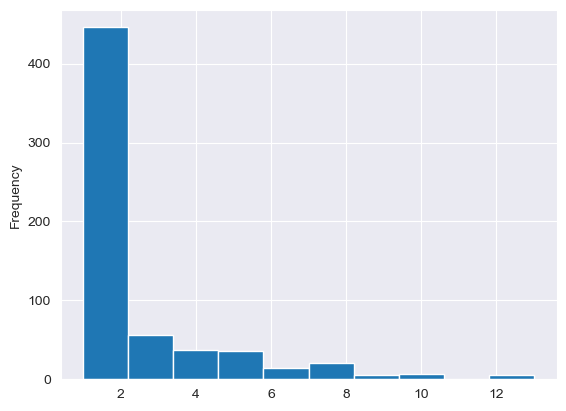

In [11]:
df['meanpressure'].value_counts().plot.hist()

In [13]:
features = ['meanpressure', 'humidity', 'wind_speed']
target = 'meantemp'

In [14]:
for lag in range(3, 0, -1):
    for feature in features + [target]:
        df[f'{feature}_lag{lag}'] = df[feature].shift(lag)

In [15]:
df

,meantemp,humidity,wind_speed,meanpressure,meanpressure_lag3,humidity_lag3,wind_speed_lag3,meantemp_lag3,meanpressure_lag2,humidity_lag2,wind_speed_lag2,meantemp_lag2,meanpressure_lag1,humidity_lag1,wind_speed_lag1,meantemp_lag1
date,,,,,,,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,7.400000,92.000000,2.980000,1017.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1015.666667,84.500000,0.000000,10.000000
2013-01-03,7.166667,87.000000,4.633333,1018.666667,NaN,NaN,NaN,NaN,1015.666667,84.500000,0.000000,10.000000,1017.800000,92.000000,2.980000,7.400000
2013-01-04,8.666667,71.333333,1.233333,1017.166667,1015.666667,84.500000,0.000000,10.000000,1017.800000,92.000000,2.980000,7.400000,1018.666667,87.000000,4.633333,7.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,1017.800000,92.000000,2.980000,7.400000,1018.666667,87.000000,4.633333,7.166667,1017.166667,71.333333,1.233333,8.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217,1014.350000,94.300000,9.085000,14.000000,1016.952381,74.857143,8.784211,17.142857,1017.200000,67.550000,8.335000,16.850000
2016-12-29,15.238095,87.857143,6.000000,1016.904762,1016.952381,74.857143,8.784211,17.142857,1017.200000,67.550000,8.335000,16.850000,1015.565217,68.043478,3.547826,17.217391
2016-12-30,14.095238,89.666667,6.266667,1017.904762,1017.200000,67.550000,8.335000,16.850000,1015.565217,68.043478,3.547826,17.217391,1016.904762,87.857143,6.000000,15.238095


In [16]:
df.drop(columns=features, inplace=True)

In [17]:
df.dropna(axis=0, inplace=True)

In [18]:
df

,meantemp,meanpressure_lag3,humidity_lag3,wind_speed_lag3,meantemp_lag3,meanpressure_lag2,humidity_lag2,wind_speed_lag2,meantemp_lag2,meanpressure_lag1,humidity_lag1,wind_speed_lag1,meantemp_lag1
date,,,,,,,,,,,,,
2013-01-04,8.666667,1015.666667,84.500000,0.000000,10.000000,1017.800000,92.000000,2.980000,7.400000,1018.666667,87.000000,4.633333,7.166667
2013-01-05,6.000000,1017.800000,92.000000,2.980000,7.400000,1018.666667,87.000000,4.633333,7.166667,1017.166667,71.333333,1.233333,8.666667
2013-01-06,7.000000,1018.666667,87.000000,4.633333,7.166667,1017.166667,71.333333,1.233333,8.666667,1016.500000,86.833333,3.700000,6.000000
2013-01-07,7.000000,1017.166667,71.333333,1.233333,8.666667,1016.500000,86.833333,3.700000,6.000000,1018.000000,82.800000,1.480000,7.000000
2013-01-08,8.857143,1016.500000,86.833333,3.700000,6.000000,1018.000000,82.800000,1.480000,7.000000,1020.000000,78.600000,6.300000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,1014.350000,94.300000,9.085000,14.000000,1016.952381,74.857143,8.784211,17.142857,1017.200000,67.550000,8.335000,16.850000
2016-12-29,15.238095,1016.952381,74.857143,8.784211,17.142857,1017.200000,67.550000,8.335000,16.850000,1015.565217,68.043478,3.547826,17.217391
2016-12-30,14.095238,1017.200000,67.550000,8.335000,16.850000,1015.565217,68.043478,3.547826,17.217391,1016.904762,87.857143,6.000000,15.238095


In [19]:
x = df.drop(columns='meantemp')
y = df['meantemp']

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.2, shuffle=False)

# RandomForestRegressor (Bagging)

In [21]:
model_rf = RandomForestRegressor(n_estimators=100)

model_rf.fit(x_train, y_train)

RandomForestRegressor()

In [22]:
y_pred = model_rf.predict(x_test)

In [25]:
print('RandomForestRegressor Estimator: ', mean_squared_error(y_test, y_pred))
print('RandomForestRegressor Estimator: ', mean_absolute_error(y_test, y_pred))
print('RandomForestRegressor Estimator: ', r2_score(y_test, y_pred))

RandomForestRegressor Estimator:  3.4302923051683587
RandomForestRegressor Estimator:  1.434745427303738
RandomForestRegressor Estimator:  0.9369635882163556


# XGBoost - Boosting

In [26]:
model_xgb = XGBRegressor(n_estimators = 100)

model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [27]:
y_pred_xgb = model_xgb.predict(x_test)

In [28]:
print('XGBoost Estimator: ', mean_squared_error(y_test, y_pred))
print('XGBoost Estimator: ', mean_absolute_error(y_test, y_pred))
print('XGBoost Estimator: ', r2_score(y_test, y_pred))

XGBoost Estimator:  3.4302923051683587
XGBoost Estimator:  1.434745427303738
XGBoost Estimator:  0.9369635882163556


# Neural Network

In [126]:
x = df.drop(columns='meantemp')
y = df['meantemp']

In [127]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

In [128]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, train_size=0.2, shuffle=False)

In [129]:
x_train.shape

(291, 12)

In [130]:
lags = 3

In [131]:
x_train_reshaped = x_train.reshape((x_train.shape[0], (x_train.shape[1] // lags), lags))
x_test_reshaped = x_test.reshape((x_test.shape[0], (x_test.shape[1] // lags), lags))

In [117]:
x_train_reshaped.shape

(291, 4, 3)

In [39]:
y_train.shape

(291, 1)

In [132]:
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape = (x_train_reshaped.shape[1], x_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='linear')
])

In [133]:
model.compile(loss='mse', optimizer='adam', metrics = ['mean_squared_error'])

In [134]:
history = model.fit(x_train_reshaped, y_train, validation_split=0.1,
    epochs=30,
    batch_size=32,
    verbose=1)

Epoch 1/30
9/9 [==============================] - 1s 26ms/step - loss: 0.4076 - mean_squared_error: 0.4076 - val_loss: 0.3491 - val_mean_squared_error: 0.3491
Epoch 2/30
9/9 [==============================] - 0s 5ms/step - loss: 0.3219 - mean_squared_error: 0.3219 - val_loss: 0.2477 - val_mean_squared_error: 0.2477
Epoch 3/30
9/9 [==============================] - 0s 4ms/step - loss: 0.2206 - mean_squared_error: 0.2206 - val_loss: 0.1156 - val_mean_squared_error: 0.1156
Epoch 4/30
9/9 [==============================] - 0s 4ms/step - loss: 0.0972 - mean_squared_error: 0.0972 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 5/30
9/9 [==============================] - 0s 4ms/step - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 6/30
9/9 [==============================] - 0s 4ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 7/30
9/9 [==============================] - 0

<Axes: >

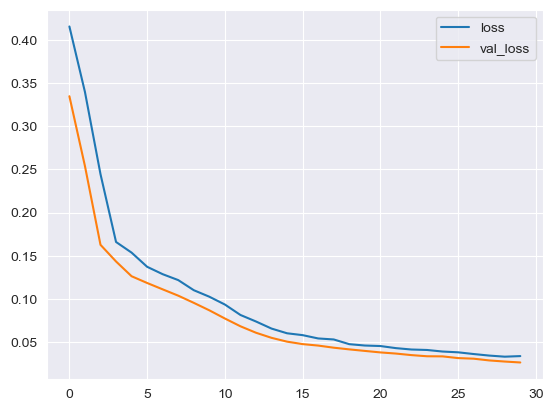

In [89]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [135]:
y_pred_nn = model.predict(x_test_reshaped)

37/37 [==============================] - 0s 717us/step


In [124]:
#y_pred_nn = scaler_y.inverse_transform(y_pred_nn)

In [136]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_nn)))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_nn))
print('R2 Score:', r2_score(y_test, y_pred_nn))

Root Mean Squared Error: 0.09069421379326446
Mean Absolute Error: 0.07187163105278803
R2 Score: 0.838231335502832
